In [2]:
import pandas as pd
import numpy as np
import os
import csv
import gzip
import sys
import datetime
import ast
import matplotlib.pyplot as plt
import scipy.stats as SSA
import statsmodels.api as sm
from scipy.stats import pearsonr
from collections import Counter

In [3]:
score_path = '../results/scores/'
df_scores = pd.read_csv(score_path+'1_3_dat_unique_item.csv')
df_td = df_scores.drop_duplicates(subset='ResponseId', keep='first')
df_agency = pd.read_csv(score_path+'agency_scores.csv')
df_gainloss = pd.read_csv(score_path+'dat_lossgain_scores.csv')
# df_td = pd.read_csv(score_path+'td_scores.csv')
print('td score len:', len(df_td), 'loss aversion score len:', len(df_gainloss), 'agency score len:', len(df_agency)) ## align with R results
### use inner join to merge the dataframes

td score len: 1349 loss aversion score len: 1348 agency score len: 1344


In [4]:
def scale_to_100(x, min_val, max_val):
    """
    Scale a given value x from its original range [min_val, max_val] to [0, 100].
    
    Parameters:
    - x: The value to scale.
    - min_val: The minimum value of the original range.
    - max_val: The maximum value of the original range.
    
    Returns:
    - The scaled value in the range [0, 100].
    """
    return (x - min_val) * 100 / (max_val - min_val)

In [5]:
# Add up all columns ending with '_avail' and '_realistic', ignoring NA
avail_sum = df_agency.filter(like='_avail').sum(axis=1, skipna=True)
realistic_sum = df_agency.filter(like='_realistic').sum(axis=1, skipna=True)

# Adding the sums as new columns to the dataframe
df_agency['total_avail'] = avail_sum
df_agency['total_realistic'] = realistic_sum
df_agency['num_items'] = df_agency.apply(lambda row: row[1:19].notna().sum(), axis=1)

In [6]:
df_agency['num_items'].unique()

array([16, 14, 18])

In [7]:
print('item=14', sum(df_agency['num_items'] == 14))
print('item=16', sum(df_agency['num_items'] == 16))
print('item=18', sum(df_agency['num_items'] == 18))
#### most of them answered 16 items and then we used 16 items for rescaling
df_agency['rescale_avail'] = df_agency['total_avail'] / (df_agency['num_items'] / 2) * 8
df_agency['rescale_realistic'] = df_agency['total_realistic'] / (df_agency['num_items'] / 2) * 8
df_agency['agency'] = df_agency['rescale_avail'] + df_agency['rescale_realistic']

item=14 392
item=16 733
item=18 219


In [8]:
df_td_select = df_td[['ResponseId', 'zipcode', 'alloc_debt', 'alloc_spend', 'alloc_save',
       'alloc_invest', 'Age', 'Risk_preference', 'score', 'presbias',
       'absolmag', 'gainloss']]
df_scores = pd.merge(df_td_select,df_gainloss,on='ResponseId',how='inner')
# df_agency_selected = df_agency[['ResponseId', 'total_avail',
#        'total_realistic', 'num_items', 'rescale_avail', 'rescale_realistic','agency',]]
df_agency_selected = df_agency[['ResponseId', 'total_avail',
       'total_realistic', 'num_items', 'rescale_avail', 'rescale_realistic','agency','agency_pub_trans_avail', 'agency_pub_trans_realistic',
       'agency_uber_avail', 'agency_uber_realistic', 'agency_delivery_avail',
       'agency_delivery_realistic', 'agency_grocery_avail',
       'agency_grocery_realistic', 'agency_pharma_avail',
       'agency_pharma_realistic', 'agency_docs_avail', 'agency_docs_realistic',
       'agency_online_avail', 'agency_online_realistic',
       'agency_IP_safe_avail', 'agency_IP_safe_realistic',
       'agency_remote_avail', 'agency_remote_realistic']]
df_merged_scores = df_scores.merge(df_agency_selected,on='ResponseId',how='inner')

In [9]:
len(df_merged_scores)

1344

In [10]:
### this depends on the number of items in each type of socres
min_agency, max_agency = -32, 32  
min_td, max_td = 0, 16   
min_loss, max_loss = 0, 6 

In [11]:
regulated_agency = scale_to_100(df_merged_scores['agency'], min_agency, max_agency)
regulated_scores = scale_to_100(df_merged_scores['score'], min_td, max_td)
regulated_loss = scale_to_100(df_merged_scores['loss_aversion_scores'], min_loss, max_loss) 

In [12]:
df_merged_scores['regulated_agency'] = regulated_agency
df_merged_scores['regulated_tdscores'] = regulated_scores
df_merged_scores['regulated_loss'] = regulated_loss

### aggrated to modzcta level

In [13]:
zip_modzcta = pd.read_csv('../results/counts/modzcta_zip_counts.csv')

In [14]:
df_merged_scores['zipcode'] = df_merged_scores['zipcode'].astype(str)
df_merged_scores['zipcode_5'] = df_merged_scores['zipcode'].str.slice(0, 5).astype(int)

In [15]:
df_merged_scores_mod = df_merged_scores.merge(zip_modzcta, left_on='zipcode_5', right_on='zip_code', how='left')

In [16]:
print(len(df_merged_scores_mod))

1344


In [17]:
for col in ['regulated_tdscores', 'regulated_loss', 'regulated_agency']:
    print(col)
    print ('mean', df_merged_scores_mod[col].mean())
    print ('std', df_merged_scores_mod[col].std())
    print ('min', df_merged_scores_mod[col].min())
    print ('p25', df_merged_scores_mod[col].quantile(0.25))
    print ('median', df_merged_scores_mod[col].median())
    print ('p75', df_merged_scores_mod[col].quantile(0.75))
    print ('max', df_merged_scores_mod[col].max())

regulated_tdscores
mean 65.46688988095238
std 20.207484838161182
min 0.0
p25 50.0
median 68.75
p75 81.25
max 100.0
regulated_loss
mean 61.049107142857146
std 22.503204464375266
min 0.0
p25 50.0
median 66.66666666666667
p75 83.33333333333333
max 100.0
regulated_agency
mean 68.01903595639645
std 17.71042530401614
min 0.0
p25 57.645089285714285
median 69.44444444444444
p75 80.35714285714286
max 100.0


In [18]:
selected_columns = ['score', 'gain_bias', 'loss_bias', 
                    'loss_aversion_scores', 'rescale_avail', 'rescale_realistic','agency',
                    'regulated_tdscores','regulated_agency','regulated_loss']
aggregations = {col: ['mean', 'median', 'std'] for col in selected_columns}
df_aggregated = df_merged_scores_mod.groupby('MODZCTA').agg(aggregations)
df_aggregated.reset_index(inplace=True)
df_aggregated.columns = ['_'.join(col).strip() for col in df_aggregated.columns.values]
df_aggregated.rename(columns={'MODZCTA_':'MODZCTA'},inplace=True)

In [19]:
len(df_aggregated)

127

In [20]:
modzcta_counts = zip_modzcta[['MODZCTA','modzcta_count']].copy()
modzcta_counts.drop_duplicates(subset='MODZCTA', inplace=True)
df_aggregated = df_aggregated.merge(modzcta_counts, on='MODZCTA', how='left')

In [17]:
# df_aggregated.to_csv(score_path+'modzcta_scores.csv',index=False)

### add other columns of the survey

In [21]:
### can be used in the future
df_survey = pd.read_csv('../results/scores/person_info.csv')

In [22]:
df_survey_select = df_survey[['ResponseId','expectation_num',
 'internet_num',
 'financial_2020_num',
 'financial_now_num',
 'financial_change_num',
 'credit_debt_num', 'age_num',
 'gender_num',
 'education_num',
 'employment_num',
 'race_num','destination']]

In [23]:
df_all_survey_num = df_merged_scores_mod.merge(df_survey_select,on='ResponseId',how='left')

In [ ]:
# df_all_survey_num.to_csv('survey_scores_perinfo_v2.csv')
# df_all_survey_num.to_csv('survey_scores_perinfo.csv')

### check the correlations at individual level

In [24]:
df_all_survey_num['financials'] = df_all_survey_num['financial_2020_num'] 
# + df_all_survey_num['financial_now_num'] + df_all_survey_num['financial_change_num']

min_max_dic = {}
col_ls = [ 'alloc_debt', 'alloc_spend', 'alloc_save',
       'alloc_invest', 'age_num',
       'expectation_num', 'financial_2020_num',
       'credit_debt_num',  'education_num', 'employment_num','financials','financial_now_num', 'financial_change_num'
       ] # 
for col in col_ls:
    print(df_all_survey_num[col].min(), df_all_survey_num[col].max(), col)
    min_max_dic[col] = [df_all_survey_num[col].min(), df_all_survey_num[col].max()]

0 1000 alloc_debt
0 1000 alloc_spend
0 1000 alloc_save
0 1000 alloc_invest
22.0 89.0 age_num
1.0 5.0 expectation_num
1.0 6.0 financial_2020_num
1.0 6.0 credit_debt_num
1.0 7.0 education_num
0.0 6.0 employment_num
1.0 6.0 financials
1.0 6.0 financial_now_num
1.0 5.0 financial_change_num


In [25]:
for col in col_ls:
    df_all_survey_num[col+'_scaled'] = df_all_survey_num[col].apply(lambda x: scale_to_100(x, min_max_dic[col][0], min_max_dic[col][1]))

In [28]:
col_new = [col+'_scaled' for col in col_ls]
df = df_all_survey_num[col_new]
df[df.isna().any(axis=1)]

,alloc_debt_scaled,alloc_spend_scaled,alloc_save_scaled,alloc_invest_scaled,age_num_scaled,expectation_num_scaled,financial_2020_num_scaled,credit_debt_num_scaled,education_num_scaled,employment_num_scaled,financials_scaled,financial_now_num_scaled,financial_change_num_scaled
108,50.0,20.0,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
823,75.0,10.0,12.5,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
824,100.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
col_new = [col+'_scaled' for col in col_ls]
df = df_all_survey_num[col_new]
df = df.dropna()
n_col = len(col_new)     
corr_matrix = pd.DataFrame(np.zeros((n_col, n_col)), 
                           index=col_new, columns=col_new)
pval_matrix = pd.DataFrame(np.ones((n_col, n_col)), 
                            index=col_new, columns=col_new)
for i in range(n_col):
    for j in range(n_col):
        if i == j:
            corr_matrix.iloc[i, j] = 1.0
            pval_matrix.iloc[i, j] = 0.0
        elif j > i:
            var1 = df.iloc[:, i]
            var2 = df.iloc[:, j]
            corr, pval = pearsonr(var1, var2)
            corr_matrix.iloc[i, j] = corr
            corr_matrix.iloc[j, i] = corr  # Symmetric matrix
            pval_matrix.iloc[i, j] = pval
            pval_matrix.iloc[j, i] = pval  # Symmetric matrix


In [27]:
print(len(df_all_survey_num))
df_zip_mod = pd.read_csv("../results/counts/modzcta_zip_counts.csv")
df_all_survey_num['zipcode_5'] = df_all_survey_num['zipcode'].str.slice(0, 5).astype(float)
select_zipcode = df_zip_mod[df_zip_mod['modzcta_count'] > 15]['zip_code'].values
np.sum(df_all_survey_num['zipcode_5'].isin(select_zipcode))

1344


1049

### individual level analysis

In [ ]:
# df_raw = df_all_survey_num

def get_reg_bindata(df_raw,score_col,select_col,bins):
    print(score_col)
    df_all_cleaned = df_raw.dropna(subset=[select_col])
    
    x = df_all_cleaned[select_col].values
    y = df_all_cleaned[score_col].values
    
    sorted_pairs = sorted(zip(x, y), key=lambda pair: pair[0])
    x_sorted, y_sorted = zip(*sorted_pairs)
    x_sorted = list(x_sorted)
    y_sorted = list(y_sorted)
    corr, p_value = pearsonr(x_sorted, y_sorted)
    print('Raw data: Pearson correlation:', corr, 'p-value:', p_value)
    xx = sm.add_constant(x_sorted)
    # Fit the linear regression model
    model = sm.OLS(y_sorted, xx)
    results = model.fit()
    predictions = results.get_prediction(xx)
    print(results.summary())
    pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI
    # Bin the x-values into 6 bins
    # bins = np.linspace(min(x)-1e-6, max(x)+1e-6, 6)  # bin_num Define bin edges
    print('bins:', bins, set(x))
    df = pd.DataFrame({'x': x, 'y': y})
    df['x_binned'] = pd.cut(df['x'], bins=bins, labels=False)  # Binned x values
    # Group by bin and calculate mean x, mean y
    binned_data = df.groupby('x_binned').agg({'x': 'mean', 'y': 'mean'}).reset_index()
    # Fit the OLS model on the binned data
    X_binned = sm.add_constant(binned_data['x'])
    model_2 = sm.OLS(binned_data['y'], X_binned)
    results_2 = model_2.fit()
    # Generate predictions and confidence intervals for the binned data
    predictions_2 = results_2.get_prediction(X_binned)
    pred_summary_2 = predictions_2.summary_frame(alpha=0.05)  # 95% CI
    return x_sorted, y_sorted, binned_data, results, pred_summary, results_2, pred_summary_2

In [45]:
bin_centers = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]

# Calculate bin edges based on bin centers
bin_edges = np.sort(
    [bin_centers[0] - (bin_centers[1] - bin_centers[0]) / 2] +  # Lower bound of the first bin
    [(bin_centers[i] + bin_centers[i + 1]) / 2 for i in range(len(bin_centers) - 1)] +
    [bin_centers[-1] + (bin_centers[-1] - bin_centers[-2]) / 2]  # Upper bound of the last bin
)

In [46]:
bin_edges

array([-10.,  10.,  30.,  50.,  70.,  90., 110.])

regulated_tdscores
Raw data: Pearson correlation: -0.10164043721916374 p-value: 0.00019283192030297375
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     13.98
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           0.000193
Time:                        09:52:14   Log-Likelihood:                -5926.4
No. Observations:                1341   AIC:                         1.186e+04
Df Residuals:                    1339   BIC:                         1.187e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

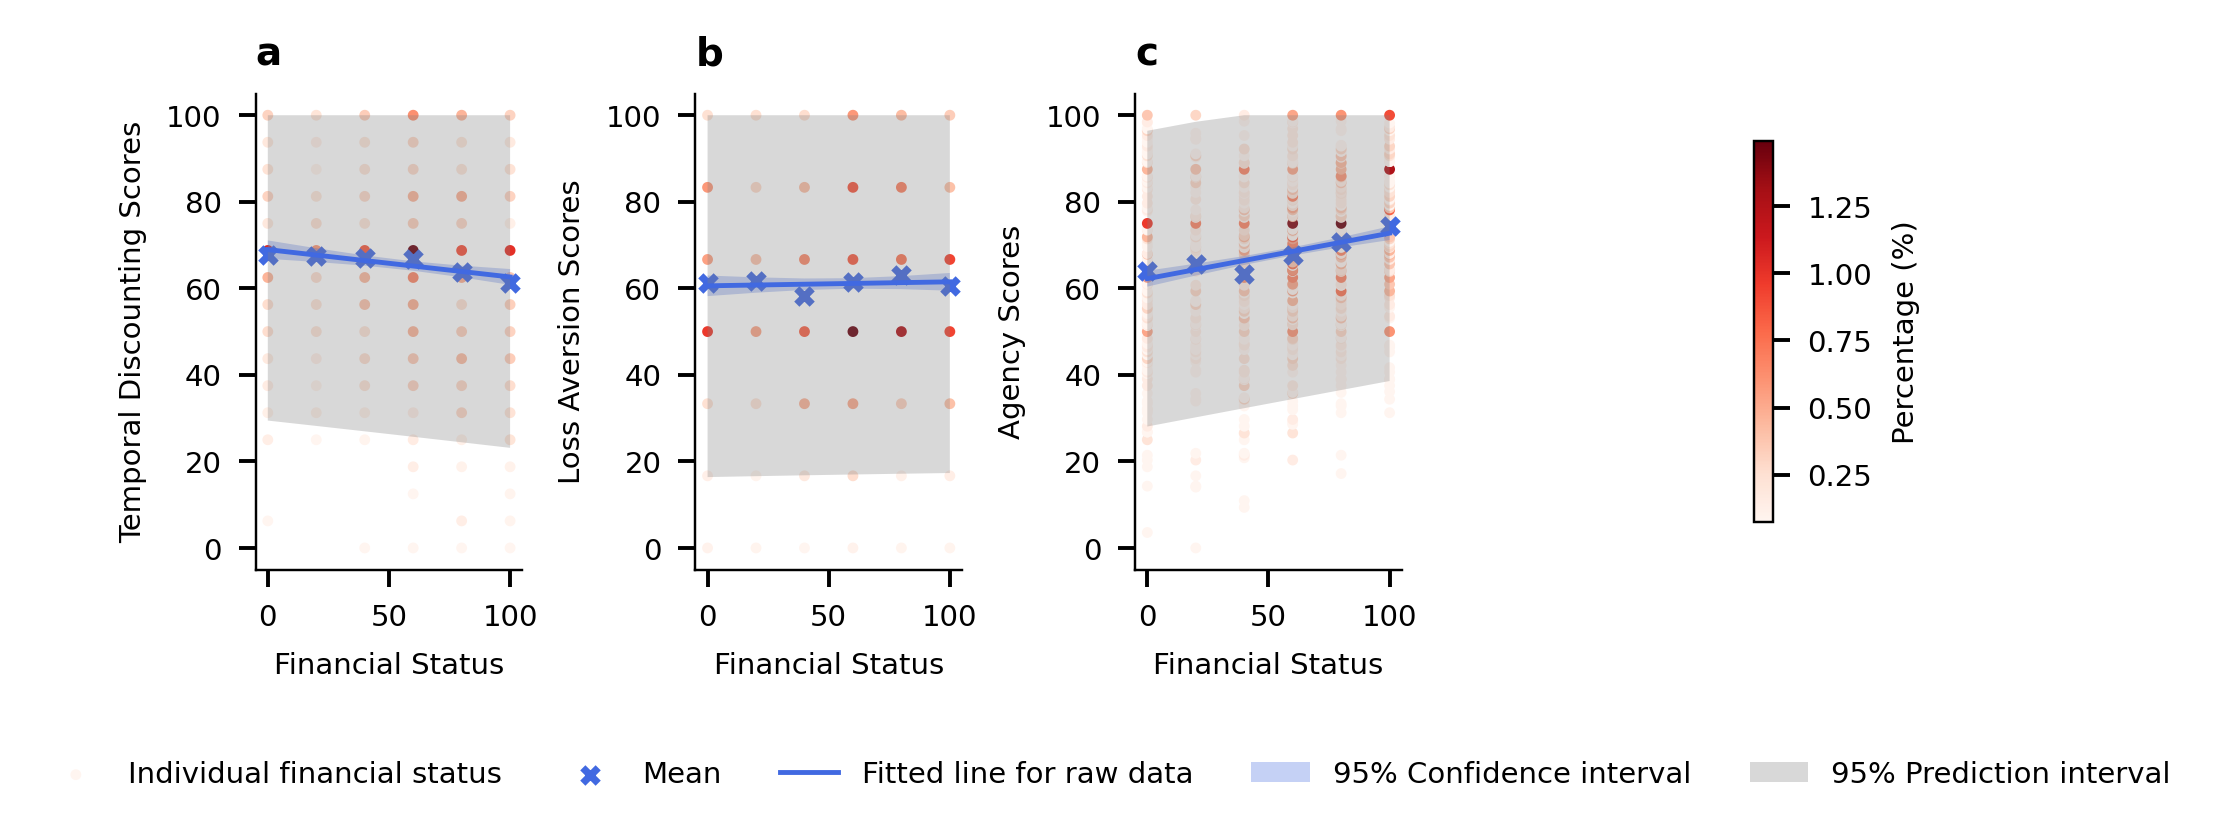

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2), dpi=350)
plt.subplots_adjust(wspace=0.65,bottom=0.2)

for i in range(3):
    score_col = ['regulated_tdscores','regulated_loss','regulated_agency'][i]
    selected_col = 'financials_scaled'
    num_bin_s = [21,10,21][i]
    results_all = get_reg_bindata(df_all_survey_num,score_col,selected_col,bin_edges)
    
    x = results_all[0]
    y = results_all[1]
    xy_pairs = list(zip(x, y))
    counts = Counter(xy_pairs)
    total_points = len(xy_pairs)
    unique_pairs = list(set(xy_pairs))
    sorted_pairs = sorted(unique_pairs, key=lambda x: x[1])
    
    colors = np.array([counts[point] / total_points * 100 for point in sorted_pairs])
    x_unique, y_unique = zip(*sorted_pairs)
    scatter = axs[i].scatter(x_unique, y_unique, c=colors, cmap='Reds', s=1.5, alpha=1, label='Individual financial status')
    print(sum(colors))
    # axs[i].scatter(results_all[0], results_all[1],s=0.25, alpha=0.5,c='grey',label='Indiviudal financial status')
    axs[i].scatter(results_all[2]['x'], results_all[2]['y'], color='royalblue', label='Mean', marker='x',s=10)

    axs[i].plot(results_all[0], results_all[4]['mean'], color='royalblue', label='Fitted line for raw data',lw=1)

    axs[i].fill_between(results_all[0], results_all[4]['mean_ci_lower'], results_all[4]['mean_ci_upper'],color='royalblue', alpha=0.3, label='95% Confidence interval',edgecolor=None)

    upper_bound = np.clip(results_all[4]['obs_ci_upper'], None, 100) ### max score is 100 
    axs[i].fill_between(results_all[0], results_all[4]['obs_ci_lower'], upper_bound, color='grey', alpha=0.3, label='95% Prediction interval',edgecolor=None)
    
    # axs[i].set_xlim([0, 100])
    # axs[i].set_ylim([0, 100])

    x_label_name = ['Temporal Discounting Scores','Loss Aversion Scores','Agency Scores'][i]
    axs[i].set_ylabel(x_label_name, fontsize=6)
    axs[i].set_xlabel('Financial Status', fontsize=6)
    
    axs[i].tick_params(axis='both', which='major', labelsize=6)
    subtitle_text = ['a','b','c']
    axs[i].set_title(subtitle_text[i], fontsize=8,loc='left',fontweight='bold')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_linewidth(0.5)  # Left spine with thinner line
    axs[i].spines['bottom'].set_linewidth(0.5) 
    
# Add colorbar for density
cbar = fig.colorbar(scatter, ax=axs, location='right', orientation='vertical', shrink=0.8, aspect=20, pad=0.2)
cbar.set_label('Percentage (%)', fontsize=6)
cbar.ax.tick_params(labelsize=6)
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.5)  # Set spine width to 0.5


# fig.text(0.5, -0.2, 'Individual Temporal Discounting Scores', ha='center', fontsize=8)
# fig.text(0.04, 0.5, 'Financial Status', va='center', rotation='vertical', fontsize=8)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15),frameon=False, ncol=5, fontsize=6)

plt.savefig('../results/plots_maps/scores_png/financials_scores_colorbar.png', dpi=350, bbox_inches='tight')

In [ ]:
df_all_survey_num.to_csv('../results/scores/survey_scores_perinfo.csv',index=False)

### check other columns

In [53]:
dic_results = {}
for i in range(3):
    score_col = ['regulated_tdscores','regulated_loss','regulated_agency'][i]
    print(score_col)
    cor_ls = []
    p_ls = []
    for selected_col in col_new:
        # print(selected_col)
        df_all_cleaned = df_all_survey_num.dropna(subset=[selected_col])
        x = df_all_cleaned[score_col].values
        y = df_all_cleaned[selected_col].values
        sorted_pairs = sorted(zip(x, y), key=lambda pair: pair[0])
        x_sorted, y_sorted = zip(*sorted_pairs)
        x_sorted = list(x_sorted)
        y_sorted = list(y_sorted)
        corr, p_value = pearsonr(x_sorted, y_sorted)
        # print('Raw data: Pearson correlation:', corr, 'p-value:', p_value)
        cor_ls.append(corr)
        p_ls.append(p_value)
    
    dic_results[score_col+'_corr'] = cor_ls
    dic_results[score_col+'_p'] = p_ls
    print('-----------------')

regulated_tdscores
-----------------
regulated_loss
-----------------
regulated_agency
-----------------


In [55]:
df_corr = pd.DataFrame(dic_results)
df_corr['names'] = col_new

In [57]:
df_corr.to_csv('../results/scores/scores_personal_corr.csv',index=False)